# Table of Contents

- [Libraries](#Libraries)
- [Data](#Data)
- [Multicolinearity](#Multicolinearity)
- [Modeling](#Modeling)
    - [K-Means](#K-Means)

# Libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, k_means
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
from scipy.spatial.distance import cdist
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
pitch_data = pd.read_csv('../datasets/mlb_pitch_stats_19_20_21.csv', index_col= ['player_id'])
pitch_data.drop(columns = ['Unnamed: 0',' first_name', 'last_name'], axis = 1, inplace = True)
print(pitch_data.shape)
pitch_data.head()

(1072, 86)


,year,age,ip,bf,ab,h,k%,bb%,ba,slg%,...,cb_brk,cb_velo_range,cu%,cu_velo,cu_spinrate,cu_hb,cu_vb,cu_brk,cu_velo_range,xops
player_id,,,,,,,,,,,,,,,,,,,,,
425794,2021,40,196.1,784,725,157,21.6,5.9,0.217,0.343,...,22.3,1.6,22.2,85.0,2408.0,6.3,-31.0,9.5,1.6,0.681
425844,2021,38,164.2,670,626,157,17.0,5.2,0.251,0.431,...,15.6,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.725
429722,2021,39,61.1,255,232,58,18.8,7.5,0.250,0.444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.851
433589,2021,37,72.1,290,273,63,12.4,4.1,0.231,0.399,...,10.7,1.8,23.3,84.5,2133.0,-1.1,-21.1,17.3,1.3,0.722
445276,2021,34,61.2,250,210,33,29.6,13.6,0.157,0.233,...,0.0,0.0,57.1,92.5,2689.0,7.3,-14.4,19.2,1.9,0.570


# Multicolinearity

In [3]:
def calc_vif(pitch_data):
    vif_data = pd.DataFrame()
    vif_data['features'] = pitch_data.columns
    vif_data['VIF'] = [variance_inflation_factor(pitch_data.values, i) 
                       for i in range(len(pitch_data.columns))]
    return(vif_data.sort_values(by = 'VIF'))

calc_vif(pitch_data).head(10)

,features,VIF
15,cg,1.364100
1,age,1.365355
81,cu_hb,1.527192
41,edge%,1.624982
29,solid_contact%,1.835575
30,poor_weak%,2.339208
60,sl_hb,2.433292
64,ch%,2.848569
74,cb_hb,2.861837
56,4seam_velo_range,2.870094


In [4]:
features = pitch_data[['cg', 'age', 'cu_hb', 'edge%', 'solid_contact%', 
                       'poor_weak%', 'sl_hb', 'ch%', 'cb_hb',
                       '4seam_velo_range']]

# Modeling

### Standardize Data

In [5]:
pitch_sc = StandardScaler().fit_transform(features)

### PCA

In [6]:
pca = PCA(n_components = None).fit(pitch_sc)

[0.18239188 0.13552444 0.1178531  0.09998678 0.09442273 0.09159754
 0.0849491  0.07376037 0.06896407 0.05054999]


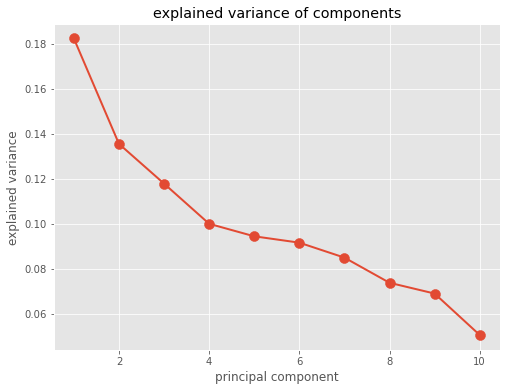

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1,11), pca.explained_variance_ratio_, lw = 2)
ax.scatter(range(1, 11), pca.explained_variance_ratio_, s = 100)
ax.set_title('explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance');
print(pca.explained_variance_ratio_)

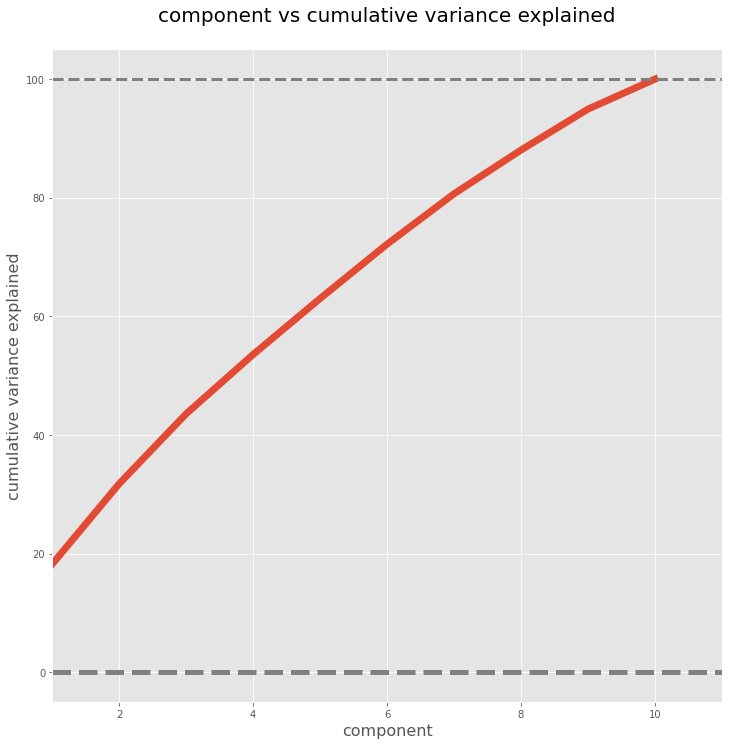

In [8]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(12,12))
component_number = range(1, 11)
plt.plot(component_number, cum_var_exp, lw=7)
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')
ax = plt.gca()
ax.set_xlim([1,11])
ax.set_ylim([-5,105])
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)  
ax.set_title('component vs cumulative variance explained\n', fontsize=20);

In [9]:
pca.components_[0],features.columns[1:]

(array([ 0.02208692, -0.0052513 ,  0.44608512, -0.17356197,  0.11166997,
        -0.2169557 ,  0.55496703, -0.30373487,  0.55301256,  0.06901294]),
 Index(['age', 'cu_hb', 'edge%', 'solid_contact%', 'poor_weak%', 'sl_hb', 'ch%',
        'cb_hb', '4seam_velo_range'],
       dtype='object'))

In [10]:
pca_component_1_eigenvec = pca.components_[0]

# combine.columns are names of coordinate axes existing in original dataset
# pca_component is the eigenvector describing a new axis
for weight, feature in zip(pca_component_1_eigenvec,
                         features.iloc[:,1:].columns):
    
    print(feature, weight)

age 0.022086924857836827
cu_hb -0.005251297032508984
edge% 0.446085118340191
solid_contact% -0.17356196647973351
poor_weak% 0.11166997471267497
sl_hb -0.2169556997044486
ch% 0.5549670250014209
cb_hb -0.30373487098551766
4seam_velo_range 0.5530125554315559


In [11]:
pitch_df = pd.DataFrame(pca.transform(pitch_sc))
pitch_df.head()

,0,1,2,3,4,5,6,7,8,9
0,2.447177,4.684049,0.062846,5.230043,-1.526056,4.022661,0.454484,-2.206620,0.665498,-0.811207
1,0.693933,2.285108,0.376970,1.909536,-0.851796,0.879678,0.801694,1.426154,1.107519,-0.065556
2,0.305526,-0.865575,1.473242,1.748387,-1.225765,-0.616132,0.872919,0.892736,0.563905,0.475441
3,-0.570992,1.045775,1.040791,0.855660,-0.880864,-0.926525,0.524481,1.537840,0.137201,-0.924731
4,1.208179,1.482939,4.359791,-0.910330,-0.486465,-0.758025,3.068878,-2.657607,-0.516625,0.339260


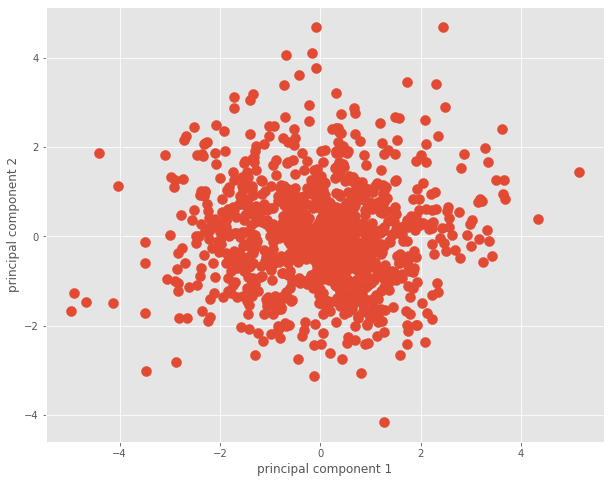

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(pitch_df.iloc[:,0], pitch_df.iloc[:,1], s=100)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2');

### K-Means

In [13]:
ss = StandardScaler()
X_scaled = ss.fit_transform(pitch_data)

In [14]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)
 
for k in K:
    km = KMeans(n_clusters=k).fit(X_scaled)
    km.fit(X_scaled)
 
    distortions.append(sum(np.min(cdist(X_scaled, km.cluster_centers_,
                                        'euclidean'), axis=1)) / X_scaled.shape[0])
    inertias.append(km.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X_scaled, km.cluster_centers_,
                                   'euclidean'), axis=1)) / X_scaled.shape[0]
    mapping2[k] = km.inertia_

In [15]:
# distortion
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 9.052690473855474
2 : 8.512377725399405
3 : 8.210769605362218
4 : 7.970259503716847
5 : 7.7900482504685575
6 : 7.66135012052518
7 : 7.585039286988266
8 : 7.502270657769665
9 : 7.384101731388854
10 : 7.313567509384102
11 : 7.241213926563843
12 : 7.1901498296232775
13 : 7.118486860719223
14 : 7.0792923219211925
15 : 7.016287087473156
16 : 6.9808762602762675
17 : 6.9208400614062455
18 : 6.892618189687972
19 : 6.863073784665674


In [16]:
# inertia
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 92192.00000000017
2 : 81485.31148841242
3 : 75805.67324914245
4 : 71760.71937222182
5 : 68659.36575314295
6 : 66636.19523697134
7 : 65159.88516297112
8 : 63074.309754957394
9 : 61354.08662514425
10 : 60195.72261321914
11 : 58977.6506372029
12 : 58176.57055023079
13 : 57132.75297197685
14 : 56500.13590163189
15 : 55671.28799368595
16 : 54962.54221129607
17 : 54134.62398717077
18 : 53544.3112443216
19 : 52978.45723626873


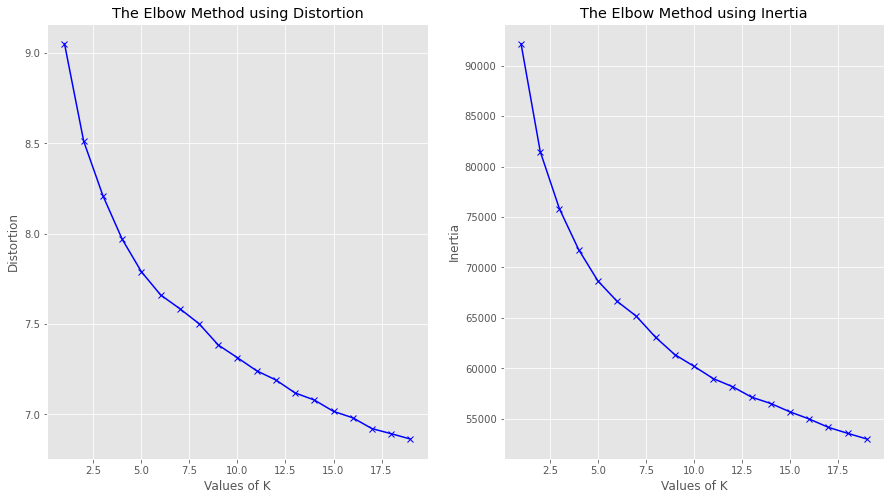

In [17]:
#https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

fig, ax = plt.subplots(1, 2, figsize = (15,8))
ax[0].plot(K, distortions, 'bx-')
ax[0].set_xlabel('Values of K')
ax[0].set_ylabel('Distortion')
ax[0].set_title('The Elbow Method using Distortion')

ax[1].plot(K, inertias, 'bx-')
ax[1].set_xlabel('Values of K')
ax[1].set_ylabel('Inertia')
ax[1].set_title('The Elbow Method using Inertia');

In [18]:
km = KMeans(n_clusters = 10,
            random_state = 0)

km.fit(pitch_data)
label = km.fit_predict(pitch_data)

print(label)

[9 3 1 ... 4 1 4]


In [19]:
len(km.labels_)

print('label:', km.labels_)
print('Number of iterations:', km.n_iter_)
print('Number of features:', km.n_features_in_)
print('Number of clusters:', km.n_clusters)
print('Inertia:', km.inertia_)
print('Silhouette Score:', silhouette_score(pitch_data, label))

label: [9 3 1 ... 4 1 4]
Number of iterations: 5
Number of features: 86
Number of clusters: 10
Inertia: 1284378316.5360928
Silhouette Score: 0.4461689934074326


In [20]:
pitch_data['label'] = label
pitch_data.head()

,year,age,ip,bf,ab,h,k%,bb%,ba,slg%,...,cb_velo_range,cu%,cu_velo,cu_spinrate,cu_hb,cu_vb,cu_brk,cu_velo_range,xops,label
player_id,,,,,,,,,,,,,,,,,,,,,
425794,2021,40,196.1,784,725,157,21.6,5.9,0.217,0.343,...,1.6,22.2,85.0,2408.0,6.3,-31.0,9.5,1.6,0.681,9
425844,2021,38,164.2,670,626,157,17.0,5.2,0.251,0.431,...,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.725,3
429722,2021,39,61.1,255,232,58,18.8,7.5,0.250,0.444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.851,1
433589,2021,37,72.1,290,273,63,12.4,4.1,0.231,0.399,...,1.8,23.3,84.5,2133.0,-1.1,-21.1,17.3,1.3,0.722,5
445276,2021,34,61.2,250,210,33,29.6,13.6,0.157,0.233,...,0.0,57.1,92.5,2689.0,7.3,-14.4,19.2,1.9,0.570,6


In [21]:
centroids = km.cluster_centers_

print('Number of Centroids:', len(centroids))
print("Predicted clusters to points: ", label[:10], '\n')
print('shape of labels:', len(km.labels_))
print('labels:', km.labels_)
print('Number of iterations:', km.n_iter_)
print('Number of features:', km.n_features_in_)
print('Number of clusters:', km.n_clusters)
print('Inertia:', km.inertia_)
print('Silhouette Score:', silhouette_score(pitch_data, label))
print("Location of centroids: ")
print(centroids)

Number of Centroids: 10
Predicted clusters to points:  [9 3 1 5 6 5 5 2 4 4] 

shape of labels: 1072
labels: [9 3 1 ... 4 1 4]
Number of iterations: 5
Number of features: 86
Number of clusters: 10
Inertia: 1284378316.5360928
Silhouette Score: 0.44617005180194313
Location of centroids: 
[[ 2.02005814e+03  2.86279070e+01  5.31558140e+01  2.25488372e+02
   2.00790698e+02  4.67093023e+01  2.58546512e+01  9.23488372e+00
   2.28779070e-01  3.81209302e-01  3.07162791e-01  6.88500000e-01
   2.35930233e+01  3.96360465e+00  1.45348837e+00  5.81395349e-02
   2.28674419e-01  3.82116279e-01  2.98918605e-01  3.03569767e-01
   3.09255814e-01  3.59093023e-01  3.65918605e-01  3.20337209e-01
   3.21779070e-01  8.88116279e+01  1.23244186e+01  3.25174419e+01
   6.98372093e+00  6.34534884e+00  4.37790698e+00  3.83220930e+01
   6.61848837e+01  1.96895349e+01  2.84546512e+01  4.48023256e+01
   5.46395349e+01  5.20197674e+01  8.99186047e+02  7.98232558e+01
   4.79802326e+01  4.23313953e+01  2.76883721e+01  4.

In [22]:
pitch_data.groupby(by = 'label').mean().T

label,0,1,2,3,4,5,6,7,8,9
year,2020.058140,2020.022472,2019.883721,2019.883333,2020.016129,2019.982906,2019.919355,2019.974026,2019.976744,2019.800000
age,28.627907,28.662921,30.046512,28.600000,28.229839,30.076923,30.112903,29.064935,29.337209,30.309091
ip,53.155814,51.003371,163.520930,147.102500,54.500000,49.810256,55.601613,50.476623,58.220930,149.154545
bf,225.488372,217.994382,681.348837,620.283333,233.895161,213.641026,234.661290,214.259740,250.116279,635.200000
ab,200.790698,193.348315,620.209302,561.625000,208.729839,191.623932,210.903226,188.623377,223.848837,576.272727
...,...,...,...,...,...,...,...,...,...,...
cu_hb,0.000000,0.000000,0.851163,0.000000,0.000000,1.352137,1.096774,0.000000,1.603488,0.698182
cu_vb,0.000000,0.000000,-27.316279,0.000000,0.000000,-27.834188,-27.154839,0.000000,-25.974419,-21.514545
cu_brk,0.000000,0.000000,9.595349,0.000000,0.000000,8.696581,8.932258,0.000000,9.956977,7.485455
cu_velo_range,0.000000,0.000000,1.511628,0.000000,0.000000,1.460684,1.443548,0.000000,1.487209,1.216364


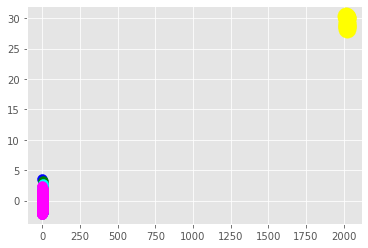

In [23]:
plt.scatter(X_scaled[label==0, 0], X_scaled[label==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X_scaled[label==1, 0], X_scaled[label==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X_scaled[label==2, 0], X_scaled[label==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(X_scaled[label==3, 0], X_scaled[label==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X_scaled[label==4, 0], X_scaled[label==4, 1], s=100, c='magenta', label ='Cluster 5')
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='yellow', label = 'Centroids');